
## Assessment of damage connected with Russia's invasion of Ukrain

Download all libraries needed for this project

In [1]:
import pandas as pd
from IPython.core.display import display
from PIL import Image
import urllib.request
import numpy as np
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots

print(plt.style.available)
mpl.style.use(['seaborn-darkgrid'])

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Read the CSV file into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

### Let's start by getting a basic understanding of the DataFrame and structuring the data

In [3]:
russian_personnel

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200
5,2022-03-02,7,5840,about,200
6,2022-03-03,8,9000,about,200
7,2022-03-04,9,9166,about,200
8,2022-03-05,10,10000,about,216
9,2022-03-06,11,11000,about,232


In [4]:
russian_personnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        48 non-null     object
 1   day         48 non-null     int64 
 2   personnel   48 non-null     int64 
 3   personnel*  48 non-null     object
 4   POW         48 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


In [5]:
russian_equipment

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system
0,2022-02-25,2,10,7,80,516,49,4,100,60,0,2,0,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130,60,2,2,0,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130,60,2,2,0,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291,60,3,2,5,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305,60,3,2,7,NaN,NaN
5,2022-03-02,7,30,31,211,862,85,40,355,60,3,2,9,NaN,NaN
6,2022-03-03,8,30,31,217,900,90,42,374,60,3,2,11,NaN,NaN
7,2022-03-04,9,33,37,251,939,105,50,404,60,3,2,18,NaN,NaN
8,2022-03-05,10,39,40,269,945,105,50,409,60,3,2,19,NaN,NaN
9,2022-03-06,11,44,48,285,985,109,50,447,60,4,2,21,NaN,NaN


In [6]:
russian_equipment = russian_equipment.fillna(0)
russian_equipment.info()
russian_equipment.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   48 non-null     object 
 1   day                    48 non-null     int64  
 2   aircraft               48 non-null     int64  
 3   helicopter             48 non-null     int64  
 4   tank                   48 non-null     int64  
 5   APC                    48 non-null     int64  
 6   field artillery        48 non-null     int64  
 7   MRL                    48 non-null     int64  
 8   military auto          48 non-null     int64  
 9   fuel tank              48 non-null     int64  
 10  drone                  48 non-null     int64  
 11  naval ship             48 non-null     int64  
 12  anti-aircraft warfare  48 non-null     int64  
 13  special equipment      48 non-null     float64
 14  mobile SRBM system     48 non-null     float64
dtypes: float

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system
0,2022-02-25,2,10,7,80,516,49,4,100,60,0,2,0,0.0,0.0
1,2022-02-26,3,27,26,146,706,49,4,130,60,2,2,0,0.0,0.0
2,2022-02-27,4,27,26,150,706,50,4,130,60,2,2,0,0.0,0.0
3,2022-02-28,5,29,29,150,816,74,21,291,60,3,2,5,0.0,0.0
4,2022-03-01,6,29,29,198,846,77,24,305,60,3,2,7,0.0,0.0


In [7]:
russian_equipment = russian_equipment.astype({'special equipment':np.int64, 'mobile SRBM system':np.int64})
russian_equipment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   date                   48 non-null     object
 1   day                    48 non-null     int64 
 2   aircraft               48 non-null     int64 
 3   helicopter             48 non-null     int64 
 4   tank                   48 non-null     int64 
 5   APC                    48 non-null     int64 
 6   field artillery        48 non-null     int64 
 7   MRL                    48 non-null     int64 
 8   military auto          48 non-null     int64 
 9   fuel tank              48 non-null     int64 
 10  drone                  48 non-null     int64 
 11  naval ship             48 non-null     int64 
 12  anti-aircraft warfare  48 non-null     int64 
 13  special equipment      48 non-null     int64 
 14  mobile SRBM system     48 non-null     int64 
dtypes: int64(14), object(1)
m

### Problem 1
##### Where is the war happening?

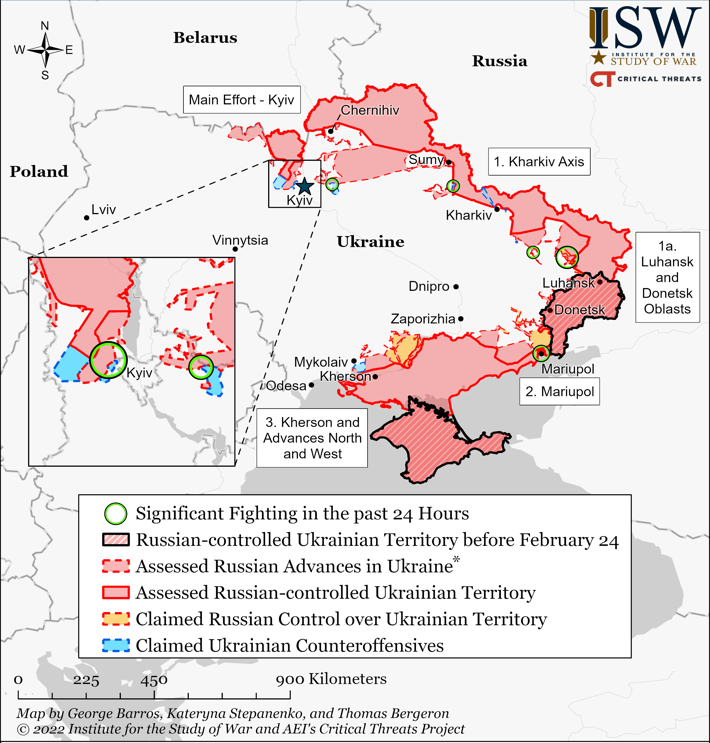

In [8]:
# Downloading data
urllib.request.urlretrieve("https://cdn.vox-cdn.com/uploads/chorus_asset/file/23351348/DraftUkraineCoTMarch28_2022.png", 
                           "study_of_war.jpg")

# Read image
img = Image.open('study_of_war.jpg').resize((710, 743))

# Display Image specs
display(img)

### Problem 2

##### Show the total Prisoners of War per day recorded in the Personel table.


Total Prisoners of War as of today is 17,163


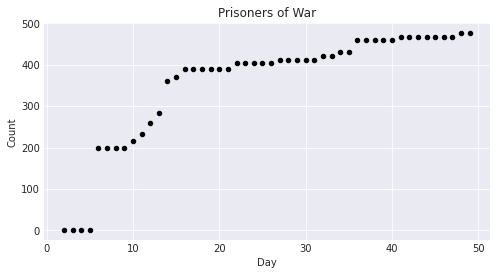

In [9]:
df = russian_personnel[["day", "POW"]]
df.set_index('day')
df.plot(kind='scatter', x='day', y='POW', color='black', figsize=(8,4), legend=False)
plt.title('Prisoners of War')
plt.xlabel('Day')
plt.ylabel('Count') 

p = "{:,}".format(sum(df['POW']))
print(f'Total Prisoners of War as of today is {p}')

### Problem 3

##### Show a comparison of the types of equipment lost per day.


In [10]:
x=russian_equipment['date']
y0=russian_equipment['aircraft']
y1=russian_equipment['helicopter']
y2=russian_equipment['tank']
y3=russian_equipment['APC']
y4=russian_equipment['field artillery']
y5=russian_equipment['MRL']
y6=russian_equipment['military auto']
y7=russian_equipment['fuel tank']
y8=russian_equipment['drone']
y9=russian_equipment['naval ship']
y10=russian_equipment['anti-aircraft warfare']
y11=russian_equipment['special equipment']
y12=russian_equipment['mobile SRBM system']

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y0, mode='lines+markers', name='Aircraft'))
fig.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name='Helicopter'))
fig.add_trace(go.Scatter(x=x, y=y2, mode='lines+markers', name='Tank'))
fig.add_trace(go.Scatter(x=x, y=y3, mode='lines+markers', name='APC'))
fig.add_trace(go.Scatter(x=x, y=y4, mode='lines+markers', name='Field Artillery'))
fig.add_trace(go.Scatter(x=x, y=y5, mode='lines+markers', name='MRL'))
fig.add_trace(go.Scatter(x=x, y=y6, mode='lines+markers', name='Military Auto'))
fig.add_trace(go.Scatter(x=x, y=y7, mode='lines+markers', name='Fuel Tank'))
fig.add_trace(go.Scatter(x=x, y=y8, mode='lines+markers', name='Drone'))
fig.add_trace(go.Scatter(x=x, y=y9, mode='lines+markers', name='Naval Ship'))
fig.add_trace(go.Scatter(x=x, y=y10, mode='lines+markers', name='Anti-Aircraft Warfare'))
fig.add_trace(go.Scatter(x=x, y=y11, mode='lines+markers', name='Special Equipment'))
fig.add_trace(go.Scatter(x=x, y=y12, mode='lines+markers', name='Mobile SRBM System'))

fig.update_layout(legend_orientation="h", 
                  legend=dict(x=0, y=0, traceorder="normal"), 
                  title="Count of Russian Weapons Lost by Type", 
                  xaxis_title="Date", 
                  yaxis_title="Number of Weapons Lost", 
                  margin=dict(l=0, r=0, t=25, b=5))

fig.show()

### Problem 4

##### What Equipment type has the highest daily loss on average? Show the first 5.


In [11]:
# find the sum of the rows then find the row with the highest value.
totals = pd.DataFrame(russian_equipment.sum(axis=0)).drop('date')
totals = totals.rename(columns={0:'Total Loss'})
totals.sort_values(by=['Total Loss'], ascending=False).head(5).transpose()

,APC,military auto,tank,field artillery,helicopter
Total Loss,68168,41703,22452,10498,4766


### Problem 5

##### Is there any correlarion between the POW and equipment loss?


<AxesSubplot:title={'center':'Correlation between Prisoners of War (POW) & Equipment Loss'}>

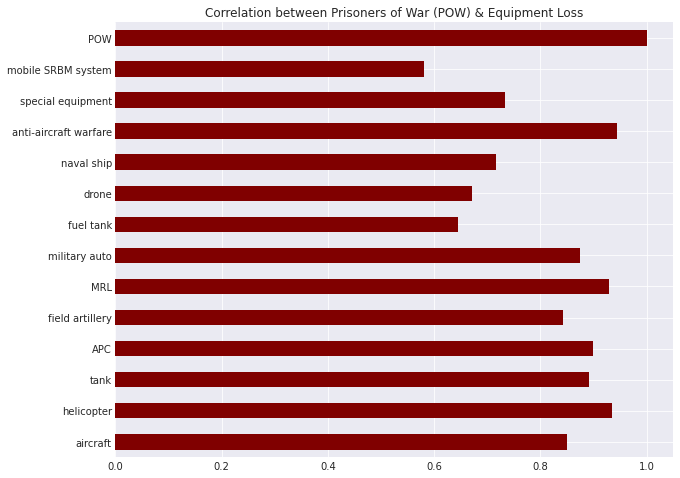

In [12]:
merged = pd.merge(russian_equipment, russian_personnel)
merged.drop(['date', 'day', 'personnel', 'personnel*'], axis=1).corr()['POW'].plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss', figsize=(10,8), color='maroon')

### Problem 6

##### What inferences can you make from the above relationship?


In [13]:
print(
    "There is a very strong, positive, direct corralation between POW and overall Equipment Loss. As the number of Prisoners os was increases, so deos the overall amount of equipment lost. The streanth in correlation, ignoring POW's direct relationship, ranges from .93 (helicopter) to .48 (fuel tanks). The Median correlation is .84 which falls between aircrafts and military auto. It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss."
    )

There is a very strong, positive, direct corralation between POW and overall Equipment Loss. As the number of Prisoners os was increases, so deos the overall amount of equipment lost. The streanth in correlation, ignoring POW's direct relationship, ranges from .93 (helicopter) to .48 (fuel tanks). The Median correlation is .84 which falls between aircrafts and military auto. It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss.
